In [0]:
!wget --header="Host: doc-04-14-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.106 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8" --header="Referer: https://drive.google.com/drive/u/1/my-drive" --header="Cookie: AUTH_h3al9pvhohi06e819h2gbg2lsu0vcm8u_nonce=6p8u8rnmvg5rc" --header="Connection: keep-alive" "https://doc-04-14-docs.googleusercontent.com/docs/securesc/e03gjc9nq28cuuoqbr2u5ongemisofpm/rtaskhc3bgge2rdilqjqcm12kre8fd57/1581773400000/12589800708188212930/12589800708188212930/152qZ0xYHvca4GP_YFmPX4WO9Ou8B_Q6T?e=download&h=06864318269717761326&authuser=1&nonce=6p8u8rnmvg5rc&user=12589800708188212930&hash=8oj1njup1ms8qfrp5ck7r7fih2jti0q3" -O "pascal.zip" -c

--2020-02-15 13:37:42--  https://doc-04-14-docs.googleusercontent.com/docs/securesc/e03gjc9nq28cuuoqbr2u5ongemisofpm/rtaskhc3bgge2rdilqjqcm12kre8fd57/1581773400000/12589800708188212930/12589800708188212930/152qZ0xYHvca4GP_YFmPX4WO9Ou8B_Q6T?e=download&h=06864318269717761326&authuser=1&nonce=6p8u8rnmvg5rc&user=12589800708188212930&hash=8oj1njup1ms8qfrp5ck7r7fih2jti0q3
Resolving doc-04-14-docs.googleusercontent.com (doc-04-14-docs.googleusercontent.com)... 216.58.193.193, 2607:f8b0:4007:80b::2001
Connecting to doc-04-14-docs.googleusercontent.com (doc-04-14-docs.googleusercontent.com)|216.58.193.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-zip-compressed]
Saving to: ‘pascal.zip’

pascal.zip              [            <=>     ] 425.44M  42.3MB/s    in 15s     

2020-02-15 13:37:58 (28.5 MB/s) - ‘pascal.zip’ saved [446107305]



In [1]:
from google.colab import drive
drive.mount('/content/gdrive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!git clone https://github.com/RaiAnant/Fastai_Multi_Object_Detector.git

Cloning into 'Fastai_Multi_Object_Detector'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 9 (delta 1), reused 8 (delta 0), pack-reused 0
Unpacking objects: 100% (9/9), done.


In [0]:
import zipfile

with zipfile.ZipFile('/content/gdrive/My Drive/pascal.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/pascal')

### Utility functions

In [0]:
import torch
from torch import nn
import torch.nn.functional as F

#return parameters for conv to pruduce required change in size
def conv_params(in_size, out_size):
    filters = [3,2,5,4]
    strides = [1,2,3] # max_stride = 3
    pads = [0,1,2,3] # max pad
    
    if out_size == 1:
        return 1, 0, in_size
    
    for filter_size in filters:
        for pad in pads:
            for stride in strides:
                if ((out_size - 1) * stride == (in_size - filter_size) + 2 * pad):
                    return stride, pad, filter_size
    return None, None, None


# Build a simple convolutional model
class StdConv(nn.Module):

    """
    A combination block of Conv2d, BatchNorm, Dropout
    """

    def __init__(self, nin, nout, filter_size=3, stride=2, padding=1, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, filter_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): 
        return self.drop(self.bn(F.relu(self.conv(x))))

#outputs a reshaped tesnor of shape (bs, x*y*k, nf//k)       
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

# This is an output convolutional model with 2 `Conv2d` layers.
class OutConv(nn.Module):

    """
    A combination block of `Conv2d`, `4 x Stride 1`, `Conv2d`, `C x Stride 1` with two layers.

    We are outputting `4 + C`
    """
    def __init__(self, k, nin, num_classes, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, (num_classes)*k, 3, padding=1) # oconv1 + flatten_conv gives C no fo filters as output
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1) # oconv1 + flatten_conv gives 4 no fo filters as output
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]
    
class SSDHead(nn.Module):
    def __init__(self, grids, anchors_per_cell, num_classes, drop=0.3, bias=-4.):
        super().__init__()
        self.drop = nn.Dropout(drop)
        
        self.sconvs = nn.ModuleList([])
        self.oconvs = nn.ModuleList([])
        
        self.anc_grids = grids
        
        self._k = anchors_per_cell # number of anchor boxes per grid

        
        self.sconvs.append(StdConv(512, 256, stride=1, drop=drop)) # doesnt change the shape (stride =1 and pad = 1)
        
        
        for i in range(len(grids)):
            
            if i == 0:
                stride, pad, filter_size = conv_params(7, grids[i]) # get '7' as input shape from base model
            else:
                stride, pad, filter_size = conv_params(grids[i-1], grids[i])
            
            if stride is None:
                print(grids[i-1], ' --> ', grids[i])
                raise Exception('cannot create model for specified grids')
                
            self.sconvs.append(StdConv(256, 256, filter_size, stride=stride, padding=pad, drop=drop))
            self.oconvs.append(OutConv(self._k, 256, num_classes=num_classes, bias=bias))
                
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconvs[0](x)
        out_classes = []
        out_bboxes = []
        print('outputs:-')
        for sconv, oconv in zip(self.sconvs[1:], self.oconvs):
            x = sconv(x)
            out_class, out_bbox = oconv(x)
            print("out_class", out_class.shape)
            print("out_bbox", out_bbox.shape)
            out_classes.append(out_class)
            out_bboxes.append(out_bbox)
            
        return [torch.cat(out_classes, dim=1),
                torch.cat(out_bboxes, dim=1)]

def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes)
        t = torch.Tensor(t[:,1:].contiguous()).cuda()
        x = pred[:,1:]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/(self.num_classes-1)
    
    def get_weight(self,x,t): return None

class FocalLoss(BCE_Loss):
    def get_weight(self,x,t):
        alpha,gamma = 0.25,1
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        w = w * (1-pt).pow(gamma)
        return w.detach()

### SingleShotDetector

In [0]:
import torch
from fastai.vision.learner import create_cnn
from torchvision.models import resnet34
import numpy as np
import json
import os
from pathlib import Path

class _EmptyData():
    def __init__(self, path, c, loss_func: None):
        self.path = path
        self.device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
        self.c = c
        self.loss_func = loss_func

class SingleShotDetector(object):
    
    def __init__(self, data, grids=[4, 2, 1], zooms=[0.7, 1., 1.3], ratios=[[1., 1.], [1., 0.5], [0.5, 1.]], 
                 backbone=None, drop=0.3, bias=-4., focal_loss=False, pretrained_path=None):
        
        super().__init__()

        self._device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')


        if backbone is None:
            backbone = resnet34
            
        self._create_anchors(grids, zooms, ratios)
        
        ssd_head = SSDHead(grids, self._anchors_per_cell, data.c, drop=drop, bias=bias)

        self._data = data
        self.learn = cnn_learner(data, models.resnet34, custom_head=ssd_head)
        self.learn.model = self.learn.model.to(self._device)

        if pretrained_path is not None:
            self.load(pretrained_path)
        
        if focal_loss:
            self._loss_f = FocalLoss(data.c)
        else:
            self._loss_f = BCE_Loss(data.c)
            
        self.learn.loss_func = self._ssd_loss

    def __call__(self, x):
        return self.learn.model(x)
    
    def eval(self):
        self.learn.model.eval()

    def train(self):
        self.learn.model.train()

    @classmethod
    def from_emd(cls, data, emd_path):
        emd = json.load(open(emd_path))
        class_mapping = {i['Value'] : i['Name'] for i in emd['Classes']}
        if data is None:
            empty_data = _EmptyData(path='str', loss_func=None, c=len(class_mapping) + 1)
            return cls(empty_data, emd['Grids'], emd['Zooms'], emd['Ratios'], pretrained_path=emd['ModelFile'])
        else:
            return cls(data, emd['Grids'], emd['Zooms'], emd['Ratios'], pretrained_path=emd['ModelFile'])

    
    def lr_find(self):
        from IPython.display import clear_output
        self.learn.lr_find()
        clear_output()
        self.learn.recorder.plot()
        
    def fit(self, epochs=10, lr=slice(1e-4,3e-3)):
        self.learn.fit(epochs, lr)

    def unfreeze():
        self.learn.unfreeze()
        
    def _create_anchors(self, anc_grids, anc_zooms, anc_ratios):
        
        self.grids = anc_grids
        self.zooms = anc_zooms
        self.ratios =  anc_ratios

        anchor_scales = [(anz*i, anz*j) for anz in anc_zooms for (i,j) in anc_ratios]
        
        self._anchors_per_cell = len(anchor_scales)
        
        anc_offsets = [1/(o*2) for o in anc_grids]

        anc_x = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag)
                                for ao,ag in zip(anc_offsets,anc_grids)])
        anc_y = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag)
                                for ao,ag in zip(anc_offsets,anc_grids)])
        anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), self._anchors_per_cell, axis=0)

        anc_sizes  =   np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) for o,p in anchor_scales])
                       for ag in anc_grids])
        
        self._grid_sizes = torch.Tensor(np.concatenate([np.array([ 1/ag  for i in range(ag*ag) for o,p in anchor_scales])
                       for ag in anc_grids])).unsqueeze(1).to(self._device)
        
        self._anchors = torch.Tensor(np.concatenate([anc_ctrs, anc_sizes], axis=1)).float().to(self._device)
        
        self._anchor_cnr = self._hw2corners(self._anchors[:,:2], self._anchors[:,2:])
        
    def _hw2corners(self, ctr, hw): 
        return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

    def _get_y(self, bbox, clas):
        bbox = bbox.view(-1,4) #/sz
        bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
        return bbox[bb_keep],clas[bb_keep]

    def _actn_to_bb(self, actn, anchors, grid_sizes):
        actn_bbs = torch.tanh(actn)
        actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
        actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
        return self._hw2corners(actn_centers, actn_hw)

    def _map_to_ground_truth(self, overlaps, print_it=False):
        prior_overlap, prior_idx = overlaps.max(1)
        if print_it: print(prior_overlap)
        gt_overlap, gt_idx = overlaps.max(0)
        gt_overlap[prior_idx] = 1.99
        for i,o in enumerate(prior_idx): gt_idx[o] = i
        return gt_overlap, gt_idx
        
        
    def _ssd_1_loss(self, b_c, b_bb, bbox, clas, print_it=False):
        bbox,clas = self._get_y(bbox,clas)
        bbox = self._normalize_bbox(bbox)

        a_ic = self._actn_to_bb(b_bb, self._anchors, self._grid_sizes)
        overlaps = self._jaccard(bbox.data, self._anchor_cnr.data)
        try:
            gt_overlap,gt_idx = self._map_to_ground_truth(overlaps,print_it)
        except Exception as e:
            return 0.,0.
        gt_clas = clas[gt_idx]
        pos = gt_overlap > 0.4
        pos_idx = torch.nonzero(pos)[:,0]
        gt_clas[~pos] = 0 #data.c - 1 # CHANGE
        gt_bbox = bbox[gt_idx]
        loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
        clas_loss  = self._loss_f(b_c, gt_clas)
        return loc_loss, clas_loss
    
    def _ssd_loss(self, pred, targ1, targ2, print_it=False):
        lcs,lls = 0.,0.
        for b_c,b_bb,bbox,clas in zip(*pred, targ1, targ2):
            loc_loss,clas_loss = self._ssd_1_loss(b_c,b_bb,bbox.cuda(),clas.cuda(),print_it)
            lls += loc_loss
            lcs += clas_loss
        if print_it: print(f'loc: {lls}, clas: {lcs}') #CHANGE
        return lls+lcs
    
    def _intersect(self,box_a, box_b):
        max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
        min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
        inter = torch.clamp((max_xy - min_xy), min=0)
        return inter[:, :, 0] * inter[:, :, 1]

    def _box_sz(self, b): 
        return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

    def _jaccard(self, box_a, box_b):
        inter = self._intersect(box_a, box_b)
        union = self._box_sz(box_a).unsqueeze(1) + self._box_sz(box_b).unsqueeze(0) - inter
        return inter / union
    
    def _normalize_bbox(self, bbox): 
        return (bbox+1.)/2.

    
    
    def save(self, name_or_path):
        if '\\' in name_or_path or '/' in name_or_path:
            path = Path(name_or_path)
            name = path.stem
            # to make fastai save to both path and with name
            temp = self.learn.path
            self.learn.path = path.parent
            self.learn.model_dir = ''
            if not os.path.exists(self.learn.path):
                os.makedirs(self.learn.path)            
            saved_path = self.learn.save(name, return_path=True)
            # undoing changes to self.learn.path and self.learn.model
            self.learn.path = temp
            self.learn.model_dir = 'models'
        else:
            temp = self.learn.path
            # fixing fastai bug
            self.learn.path = self.learn.path.parent
            if not os.path.exists(self.learn.path / self.learn.model_dir):
                os.makedirs(self.learn.path / self.learn.model_dir)            
            saved_path = self.learn.save(name_or_path,  return_path=True)
            # undoing changes to self.learn.path
            self.learn.path = temp

    def load(self, name_or_path):
        if '\\' in name_or_path or '/' in name_or_path:
            path = Path(name_or_path)
            name = path.stem
            # to make fastai from both path and with name
            temp = self.learn.path
            self.learn.path = path.parent
            self.learn.model_dir = ''
            self.learn.load(name)
            # undoing changes to self.learn.path and self.learn.model_dir
            self.learn.path = temp
            self.learn.model_dir = 'models'
        else:
            temp = self.learn.path
            # fixing fastai bug
            self.learn.path = self.learn.path.parent            
            self.learn.load(name_or_path)
            # undoing changes to self.learn.path
            self.learn.path = temp
        
    def show_results(self, rows=5, thresh=0.5, nms_overlap=0.1):
        self.learn.show_results(rows=rows, thresh=thresh, nms_overlap=nms_overlap, ssd=self)

### Pascal VOC Data

In [0]:
import fastai
import numpy as np
import pandas as pd
from pathlib import Path

from fastai.vision.transform import get_transforms
from fastai.vision.data import ObjectItemList, imagenet_stats#, bb_pad_collate
from fastai import *
from fastai.datasets import *
from fastai.vision import *

In [0]:
PATH = Path('/content/pascal')
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'
IMG_PATH = PATH/JPEGS

In [0]:
images, lbl_bbox  = get_annotations(PATH/'train.json')
images_v, lbl_bbox_v  = get_annotations(PATH/'valid.json')

img2bbox = dict(zip(images, lbl_bbox))
img2bbox_v = dict(zip(images_v, lbl_bbox_v))
def get_y_func(x):
    if x.name in img2bbox:
        bboxes, classes = img2bbox[x.name]
    else:
        bboxes, classes = img2bbox_v[x.name]
    return [bboxes, classes] 

In [0]:
from Fastai_Multi_Object_Detector.ssdoil import SSDObjectItemList

data = (SSDObjectItemList.from_folder(PATH/JPEGS)
        .split_by_files(images_v)                          
        .label_from_func(get_y_func)
        .transform(get_transforms(), tfm_y=True, size=224)
        .databunch(bs=128, collate_fn=bb_pad_collate)
        .normalize(imagenet_stats)) 

In [0]:
%%time
data.show_batch()

In [0]:
doc(Learner)

### SSD

In [0]:
ssd = SingleShotDetector(data)

### Random Testing

In [0]:
import gc
gc.collect()

4336

In [0]:
for xb, yb in ssd._data.train_dl:
    print(ssd._get_y(yb[0][0], yb[1][0]))

In [0]:
max_c = 0
for xb, yb in ssd._data.train_dl:
    if max(yb[1][0])>max_c:
        max_c = max(yb[1][0])
    print( yb[1][0])

In [0]:
x,y = next(iter(ssd._data.valid_dl))
ssd.eval()
batch = ssd(x)
b_class, b_bb = batch

RuntimeError: ignored

In [0]:
b_class.size(),b_bb.size()

(torch.Size([128, 189, 21]), torch.Size([128, 189, 4]))

In [0]:
b_class

### SSD continued

In [0]:
ssd.lr_find()

In [0]:
ssd.fit(20, lr=slice(1e-3, 1e-2))

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [0]:
ssd.save('ssd-pascal-20')

In [0]:
ssd.load('ssd-pascal-20')

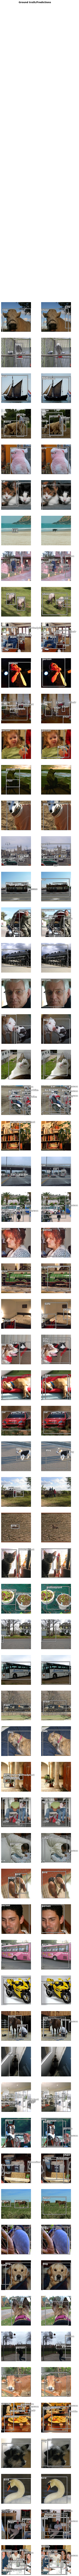

In [0]:
ssd.show_results(rows=64, thresh=0.1)

### Simple SSD 
4x4 grid with one anchor box per grid cell

In [0]:
simple_ssd = SingleShotDetector(data, grids=[4], zooms=[1.0], ratios=[[1.0, 1.0]])

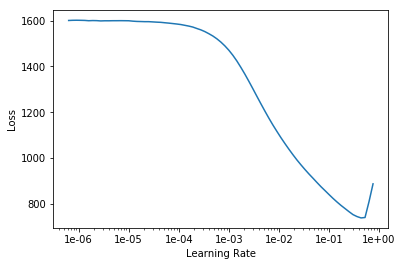

In [0]:
simple_ssd.lr_find()

In [0]:
simple_ssd.fit(10, lr=slice(1e-3, 1e-2))

In [0]:
simple_ssd.save('simplessd-pascal-10')

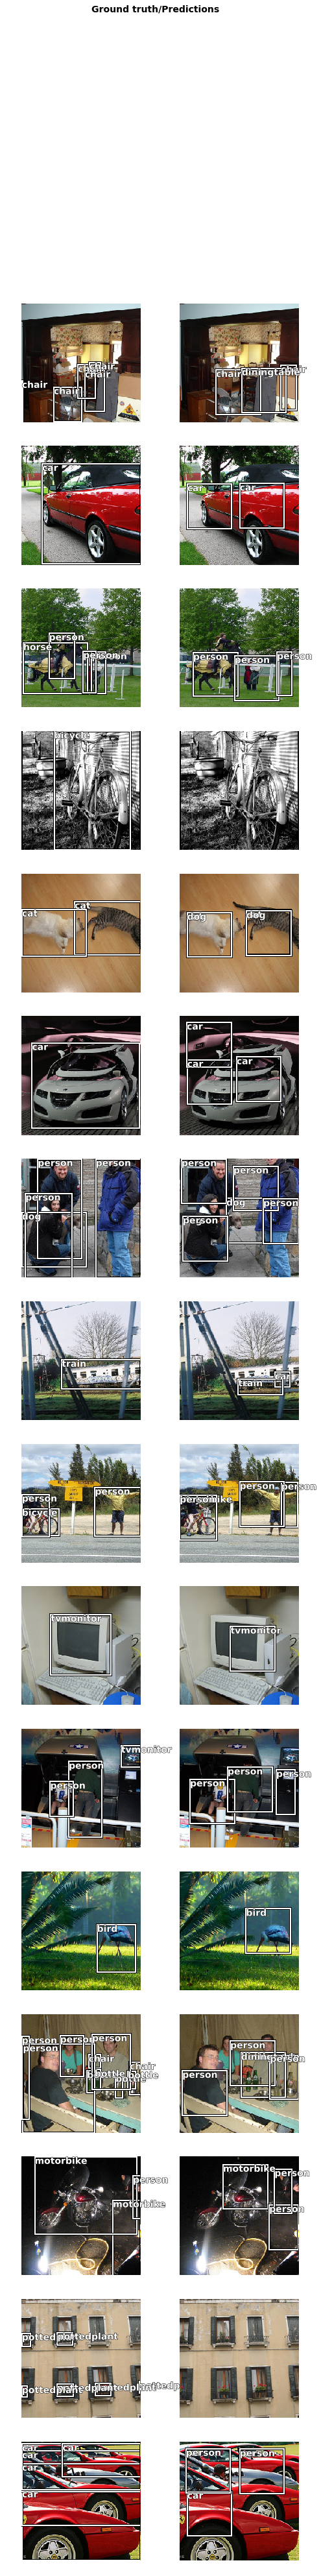

In [0]:
simple_ssd.show_results(rows=16, thresh=0.1)